<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys

bme_repo = "https://github.com/jd2504/bme_dsp_2025.git"
repo_name = bme_repo.split('/')[-1].replace('.git', '')
!git clone {bme_repo}
sys.path.append(os.path.join(os.getcwd(), repo_name))
import bmedsp_helpers as bme

Cloning into 'bme_dsp_2025'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 82 (delta 38), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 3.29 MiB | 10.40 MiB/s, done.
Resolving deltas: 100% (38/38), done.


# Regress out eye blinks

$ y = Ax $

$ \hat{A} = R_{yx}R_{xx}^{-1} $

$ n = y - \hat{A}x $

In [ ]:
import numpy as np
from scipy import signal, stats
from matplotlib import pyplot as plt

# JDRV - linear regression

In [ ]:
file_input = bme.grab_mat('eeg.mat')

https://parralab.org/teaching/biomed-dsp/eeg.mat
dict_keys(['__header__', '__version__', '__globals__', 'x', 'fs'])
b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Feb  2 17:00:13 2016'


In [ ]:
# nb params
y_channels = [5,6,7]
skip_first_n = 10
process_channels = False
plt_colors = ['grey', 'orange', 'orchid', 'blue']

In [ ]:
x_orig = file_input['x']
fs = file_input['fs'][0][0]
x_orig = x_orig[[0]+y_channels, skip_first_n:]

if process_channels:
    x_orig = stats.zscore(x_orig, axis=1)
    b, a = signal.butter(2, 1/(fs/2), 'highpass')
    x_orig = signal.lfilter(b, a, x_orig)
    x_orig = stats.zscore(x_orig, axis=1)


spacer, ylimits = bme.spacer_and_ylimits(x_orig)


# t axis
N = x_orig.shape[1]
print(f"T={N/fs}s")
x_ax = np.linspace(0, N/fs, N)

# filter

def simple_linreg(y,x):
    y_bar, x_bar = np.mean(y), np.mean(x)

    xy_sum = np.sum((x-x_bar)*(y-y_bar))
    xx_sum = np.sum((x-x_bar)**2)
    return xy_sum/xx_sum

y_params = []
y_array = []
for i in range(4):
    if i == 0:
        y_ch = np.full(N, np.nan)
    else:
        y = x_orig[i].copy()
        x_eog = x_orig[0].copy()
        b = simple_linreg(y,x_eog)
        y_params.append(b)
        y_ch = y - x_eog*b

    y_array.append(y_ch)

T=9.96s


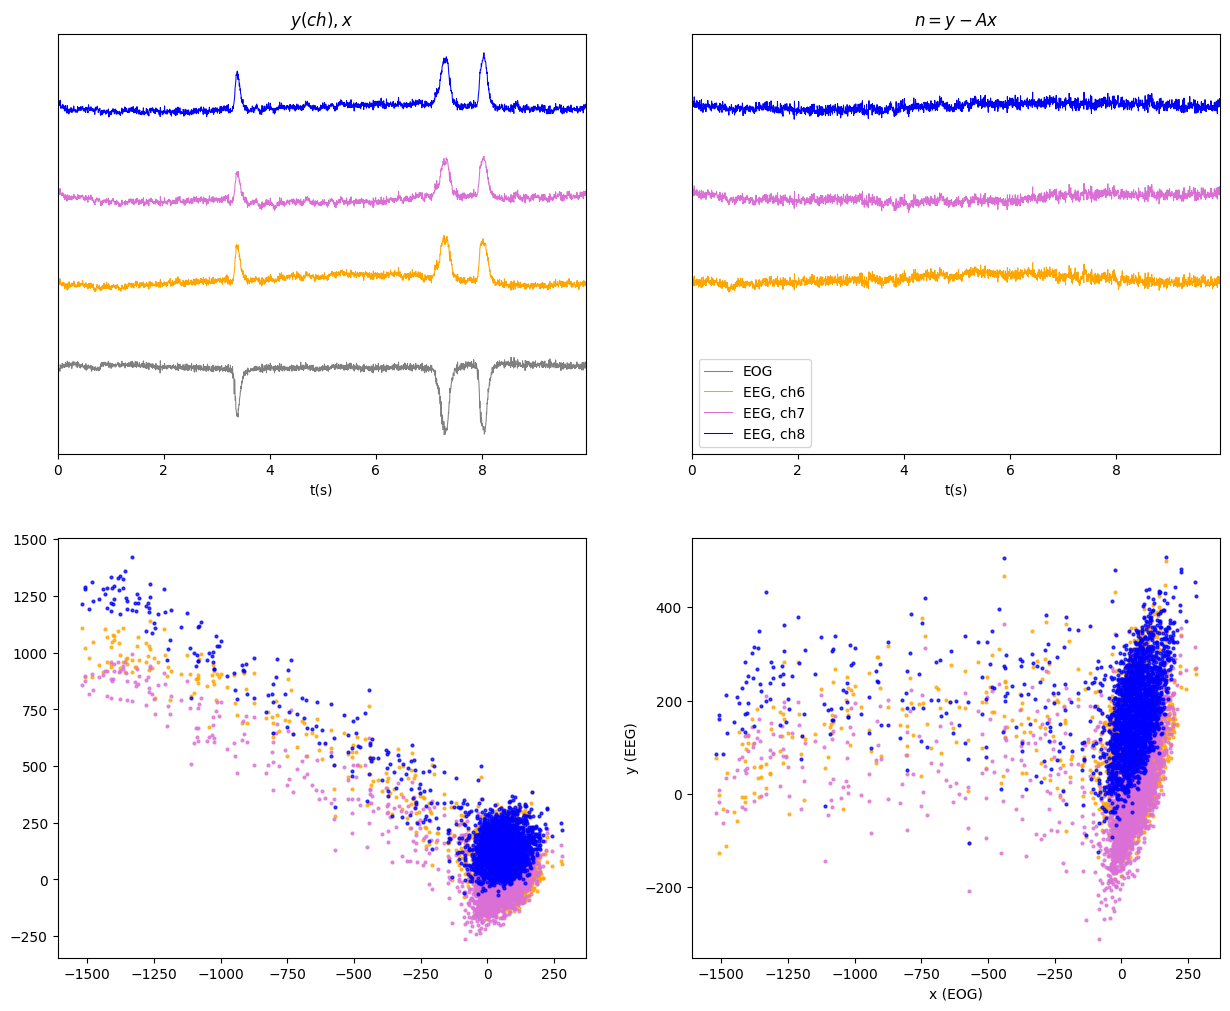

In [ ]:
# 5.14

plt.figure(figsize=(15,12))

orig_ts = plt.subplot(2,2,1)
orig_xy = plt.subplot(2,2,3)
regr_ts = plt.subplot(2,2,2)
regr_xy = plt.subplot(2,2,4)


labels = ['EOG'] + [f"EEG, ch{ch+1}" for ch in y_channels]

# orig
for i in range(4):
    orig_ts.plot(x_ax,x_orig[i] + i*spacer, c=plt_colors[i], lw=0.75, label=labels[i])
orig_ts.set_title("$y(ch), x$")
for i in range(1,4):
    orig_xy.scatter(x_orig[0], x_orig[i], s=4, c=plt_colors[i], alpha=0.75)

# eog signal regressed out
for i in range(4):
    regr_ts.plot(x_ax, y_array[i] + i*spacer, c=plt_colors[i], lw=0.75, label=labels[i])
regr_ts.set_title("$n = y - Ax$")
regr_ts.legend()
for i in range(4):
    regr_xy.scatter(x_orig[0], y_array[i], s=4, c=plt_colors[i], alpha=0.75)

# t(s) plot elements
for ax in (orig_ts, regr_ts):
    ax.set_yticks([])
    ax.set_ylim(ylimits)
    ax.set_xlim(0, max(x_ax))
    ax.set_xlabel('t(s)')
# scatterplots elements
for ax in (regr_xy, regr_xy):
    ax.set_xlabel('x (EOG)')
    ax.set_ylabel('y (EEG)')

plt.show()

# JDRV - multivariate normal distribution

$ p(x) = \frac{1}{\sqrt{(2\pi)^n | \Sigma |)}} exp [-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)] $

Mean: $ E[x] = \mu $, cov: $ E[(x-\mu)(x-\mu)^T] = \Sigma $

$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix} $,
$ \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 0.4 \end{bmatrix} $

In [ ]:
def mv_pdf_norm(x, mu, Sigma):
    n = len(x)
    det_Sigma = np.linalg.det(Sigma)
    inv_Sigma = np.linalg.inv(Sigma)
    diff = x - mu

    # (x - \mu)^T \Sigma^{-1} (x - \mu)
    term0 = np.exp(-0.5 * (diff.T @ inv_Sigma @ diff))
    # {\sqrt{(2\pi)^n | \Sigma |)}
    term1 = np.sqrt((2 * np.pi)**n * det_Sigma)
    pdf_value = 1/term1 * term0

    return pdf_value

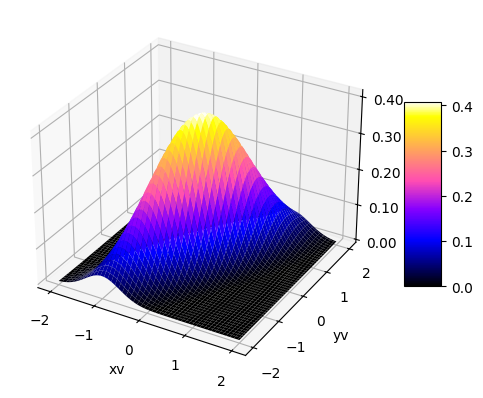

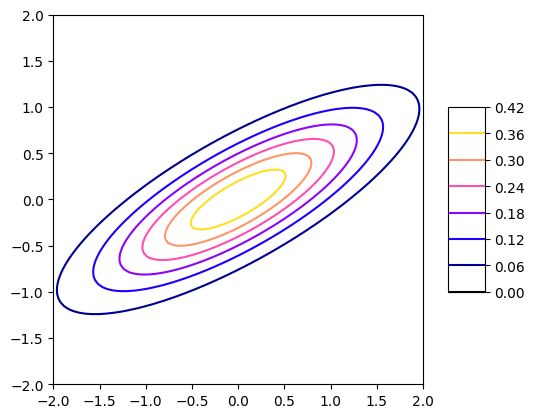

In [ ]:
# 5.15

x_pts = np.linspace(-2, 2, 100)
y_pts = np.linspace(-2, 2, 100)

mu = np.array([0.,0.])
Sigma = np.array([[1., 0.5],
                  [0.5, 0.4]])


xv, yv = np.meshgrid(x_pts, y_pts)
pdf_pts = np.vstack([xv.flatten(), yv.flatten()]).T
xy_pdf = np.array([mv_pdf_norm(i, mu, Sigma) for i in pdf_pts])
xy_pdf = xy_pdf.reshape(100, 100)


# from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(yv, xv, xy_pdf, lw=0, cmap='gnuplot2')
# ax.set_zlim(0., .5)
# ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('xv')
ax.set_ylabel('yv')
plt.show()

plt.contour(xv, yv, xy_pdf, cmap='gnuplot2')
plt.axis('scaled')
plt.colorbar(shrink=0.5, aspect=5)
plt.show()

In [ ]:
# plt.plot(pdf_pts)
# plt.show()

# plt.plot(xy_pdf)
# plt.show()

# PCA

1. Covariance Matrix for a set of Random Variables (RVs): For a set of RVs, $\mathbf{x} = [x_1, \dots, x_n]^T$, the covariance matrix is defined as: $R_{xx} = E[(\mathbf{x} - E[\mathbf{x}])(\mathbf{x} - E[\mathbf{x}])^T]$

2. Covariance Matrix for Zero-Mean RVs: This reduces for zero-mean RVs to: $R_{xx} = E[\mathbf{x}\mathbf{x}^T]$

3. Estimated Covariance Matrix from N Data Samples (for zero-mean variables): Often, the covariance matrix is estimated from a set of $N$ data samples $X = [\mathbf{x}1, \dots, \mathbf{x}N]$ using sample averages. For zero-mean variables, it is simply: $\hat{R}{xx} = \frac{1}{N} \sum{k=1}^{N} \mathbf{x}_k \mathbf{x}_k^T = \frac{1}{N} X X^T$

$ R_xx = (X - \mu)(X - \mu)^T/(N-1) $

$ R_xx U = U D $

$ W = U D^{1/2} $

$ z = D^{−1/2} U^T (X - \mu) $; $ Cov(z) ≈ I $

In [ ]:
Rxx_targ = np.array([[2.9, 1.25],
                     [1.25, 1]])

D_targ, U_targ = np.linalg.eigh(Rxx_targ)
# looking for W = U*D^(1/2)
W = U_targ @ np.diag(np.sqrt(D_targ))

z1 = np.random.randn(1000)
z2 = np.random.randn(1000)
z = np.vstack([z1, z2])
x = W @ z

mu = np.mean(x, axis=1, keepdims=True)
Xc = x - mu


Rxx_observed = np.cov(Xc)
D_obs, U_obs = np.linalg.eigh(Rxx_observed)
idx = D_obs.argsort()[::-1]
D_obs, U_obs = D_obs[idx], U_obs[:, idx]

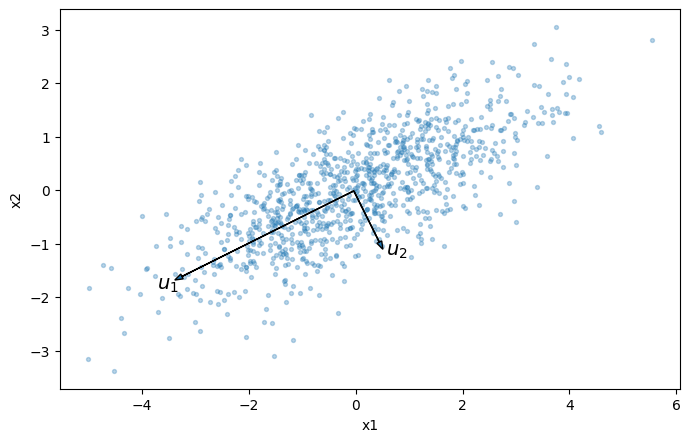

In [ ]:
plt.figure(figsize=(8,8))

plt.scatter(x[0], x[1], s=8, alpha=0.3)
origin = mu.ravel()

# scale arrows by ~2 stds
scales = 2.0 * np.sqrt(D_obs)
for k, lab in enumerate(['$u_1$', '$u_2$']):
    # U_obs cols: PCs, u_k
    end = origin + scales[k]*U_obs[:, k]
    plt.arrow(origin[0], origin[1], end[0]-origin[0], end[1]-origin[1],
              head_width=0.1, length_includes_head=True)
    plt.text(end[0]*1.1, end[1]*1.1, lab, fontsize=14)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()